In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
EXAMPLES = True

In [4]:
vmin = -180
vmax = 180
nbin = 360

# Simulation Data Analysis II

#### 1) Normalized Euclidean Distance
We present the normed euclidean distance between the $\chi_{1}$-angle of H294 in system A and B. The values were binned into 360 bins between -180 and 180.

In [5]:
def normed_euclidean_distance(x: np.ndarray, y: np.ndarray, axis=-1):
    assert x.shape[axis] == y.shape[axis]
    n = x.shape[axis]
    
    return (1/n) * np.sqrt(np.sum((x - y) ** 2, axis=axis))

In [6]:
files = ['ignore/anglesA/chi1HIS97.xvg', 'ignore/anglesB/chi1HIS97.xvg']
names = ['A', 'B']
dfs = [pd.read_csv(f, 
                   header=None, 
                   names=['time', n],
                   skiprows=17, 
                   index_col=0,
                   delim_whitespace=True) for n, f in zip(names, files)]
df = pd.concat(dfs, axis=1)

Text(0.5, 0, 'Chi1 (degree)')

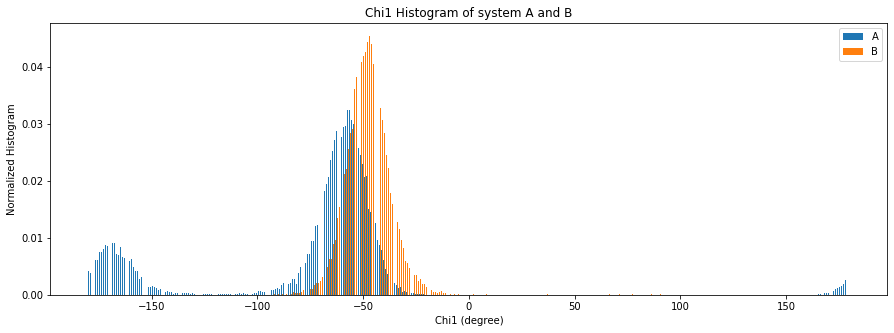

In [7]:
bins = np.linspace(vmin, vmax, nbin)
fig = plt.figure(figsize=(15, 5))
plt.hist([df['A'], df['B']], 
         density=True, 
         bins=bins, 
         histtype='bar') # 'barstacked'
plt.title('Chi1 Histogram of system A and B')
plt.legend(['A', 'B'])
plt.ylabel('Normalized Histogram')
plt.xlabel('Chi1 (degree)')

In [8]:
A, _ = np.histogram(df['A'], bins=nbin, range=(vmin, vmax), density=True)
B, _ = np.histogram(df['B'], bins=nbin, range=(vmin, vmax), density=True)

In [9]:
delta = normed_euclidean_distance(A, B)
print(f"The normed euclidean distance between the chi1 angles in system A and B is {delta}.")

The normed euclidean distance between the chi1 angles in system A and B is 0.0003256800752222079.


#### 2) Kullback-Leibler Divergence

We estimate the Kullback-Leibler divergence between the histograms of the $\chi_{1}$-angle of H294 in system A and B. Note that $\ln(p)$ is not defined in areas where $p$ is zero or undefined. For this reason, we must restrict our calculation of the kl divergence to binned regions in which we have samples for both of our distributions (histograms).

In [10]:
def kl_divergence(p: np.ndarray, q: np.ndarray):
    assert p.shape == q.shape
    return np.sum(p * (np.log(p) - np.log(q)))

if EXAMPLES:
    # Generate samples
    A = np.random.randn(10000)*0.5 + 1
    B = np.random.rand(10000) # Note, this must cover the A dist.
    
    # they must be defined on the same region, so truncate the normal
    bmax, bmin = B.max(), B.min()
    A = np.array([i for i in A if (bmin < i) and (i < bmax)])
    
    # Find a density for the purposes of calculating kl_divergence
    bins = np.linspace(bmin, bmax, num=100)
    pA, _ = np.histogram(A, bins=bins, density=True)
    pB, _ = np.histogram(B, bins=bins, density=True)
    print(kl_divergence(pA, pB))

14.723350821400059


#### 3) Mutual Information
We present the mutual information and normalized mutual information between Chi1 and Chi2 angles in system B. Notice that the mutual information calculation is undefined within parts of the histogram without any samples. To avoid this problem, we do not consider those areas in our calculation.

In [11]:
def mutual_information(pxy: np.ndarray, px: np.ndarray, py: np.ndarray):
    assert px.shape == py.shape
    assert pxy.shape == (px.shape[0], py.shape[0])
    
    ln = np.log(pxy) - np.log(np.einsum('i,j', px, py))
    to_replace = np.logical_or(np.isnan(ln), np.isinf(ln))
    ln[to_replace] = 0.0
    return np.einsum('ij,ij', pxy, ln)

# Simple Test.
if EXAMPLES:
    from scipy.special import softmax as softmax
    pq = softmax(np.random.rand(3,3))
    p = softmax(np.random.rand(3))
    q = softmax(np.random.rand(3))
    print(f"Independent case: {mutual_information(np.einsum('i,j', p, q), p, q)}")
    print(f"Randomly Dependent case: {mutual_information(pq, p, q)}")

Independent case: 0.0
Randomly Dependent case: 0.028082077449402474


In [12]:
def entropy(px: np.ndarray):
    ent = px * np.log(px)
    to_replace = np.logical_or(np.isnan(ent), np.isinf(ent))
    ent[to_replace] = 0.0
    return -np.sum(ent)

def normalized_mutual_information(pxy: np.ndarray, px: np.ndarray, py: np.ndarray):
    return mutual_information(pxy, px, py) / np.min([entropy(i) for i in [px, py]])

# Simple Test.
if EXAMPLES:
    print(f"Normalized Independent case: "
          f"{normalized_mutual_information(np.einsum('i,j', p, q), p, q)}")
    print(f"Normalized Randomly Dependent case: "
          f"{normalized_mutual_information(pq, p, q)}")

Normalized Independent case: 0.0
Normalized Randomly Dependent case: 0.025984786002157992


In [13]:
files = ['ignore/anglesB/chi1HIS97.xvg', 'ignore/anglesB/chi2HIS97.xvg']
names = ['chi1', 'chi2']
dfs = [pd.read_csv(f, 
                   header=None, 
                   names=['time', n],
                   skiprows=17, 
                   index_col=0,
                   delim_whitespace=True) for n, f in zip(names, files)]
df = pd.concat(dfs, axis=1)

Text(0.5, 0, 'Chi1 or Chi2 (degree)')

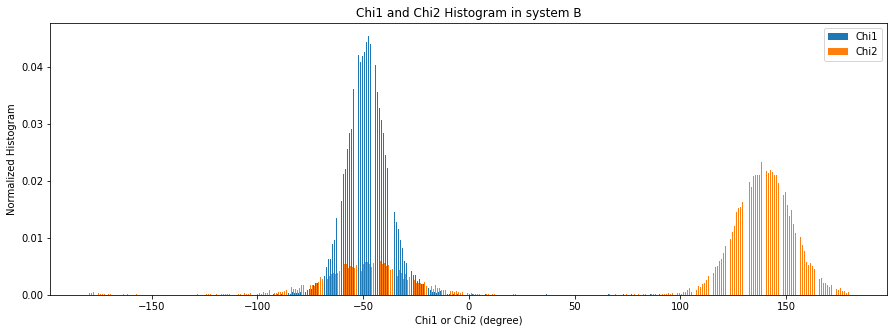

In [14]:
bins = np.linspace(-180, 180, 360)
fig = plt.figure(figsize=(15, 5))
plt.hist([df['chi1'], df['chi2']], 
         density=True, 
         bins=bins, 
         histtype='bar') # 'barstacked'
plt.title('Chi1 and Chi2 Histogram in system B')
plt.legend(['Chi1', 'Chi2'])
plt.ylabel('Normalized Histogram')
plt.xlabel('Chi1 or Chi2 (degree)')

In [15]:
AB, b1, b2 = np.histogram2d(df['chi1'], df['chi2'], 
                            bins=(nbin, nbin), range=((vmin, vmax), (vmin, vmax)), 
                            density=True)
A, bb1 = np.histogram(df['chi1'], bins=nbin, range=(vmin, vmax), density=True)
B, bb2 = np.histogram(df['chi2'], bins=nbin, range=(vmin, vmax), density=True)

In [16]:
print(f'The mutual information between Chi1 and Chi2 is {mutual_information(AB, A, B)}')
print(f'The normalized mutual information is {normalized_mutual_information(AB, A, B)}')

The mutual information between Chi1 and Chi2 is 0.43215873905877533
The normalized mutual information is 0.11620572513759658


/storage/mi/milleb92/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/storage/mi/milleb92/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
/storage/mi/milleb92/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/storage/mi/milleb92/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


#### 4) Coupling Constants
For this problem, we have to consider that the statistical and standard errors add in quadrature when considering the accuracy of each calculation method. We find that the Bax prediction is more accurate. In case "1" the Schmidt prediction was nearly outside the margin of error of the experimental value; however, in all other cases the Bax and Schmidt 

In [17]:
def karplus(phi: np.ndarray, A, B, C):
    return A * np.cos(phi - 1/3*np.pi)**2 + B * np.cos(phi - 1/3*np.pi) + C
schmidt = (7.6, -1.05, 0.65)
schmidt_error = 0.78
bax = (7.09, -1.42, 1.55)
bax_error = 0.30

In [18]:
files = [f'dropbox/{i}.ascii' for i in range(1, 6)]
names = [str(i) for i in range(1, 6)]
dfs = [pd.read_csv(f, header=None, names=[n]) for n, f in zip(names, files)]
df = pd.concat(dfs, axis=1)
df = df * np.pi/180.

In [19]:
schmidt_df = df.apply(lambda x: karplus(x, *schmidt))
bax_df = df.apply(lambda x: karplus(x, *bax))

In [20]:
experi = pd.read_csv('dropbox/experimental.dat', names=['idx', 'mean', 'std'],
                     index_col=0, delim_whitespace=True)

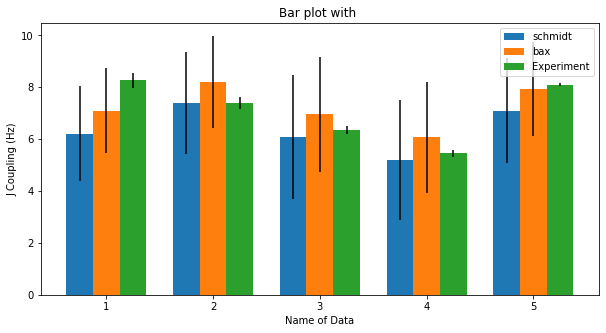

In [21]:
ind = np.arange(len(names))
width = 0.75

fig, ax = plt.subplots(figsize=(10,5))
r1 = ax.bar(ind - width/3, schmidt_df.mean(), width/3, 
            yerr=np.sqrt(schmidt_df.std()**2 + schmidt_error**2), 
            label='schmidt')
r2 = ax.bar(ind , bax_df.mean(), width/3, 
            yerr=np.sqrt(bax_df.std()**2 + bax_error**2), 
            label='bax')
r3 = ax.bar(ind + width/3, experi['mean'], width/3, 
            yerr=experi['std'], 
            label='Experiment')

ax.set_ylabel('J Coupling (Hz)')
ax.set_xlabel('Name of Data')
ax.set_title('Bar plot with ')
ax.set_xticks(ind)
ax.set_xticklabels(names)
ax.legend()